# Exercise 4, Movement Primitives

## Lab Instructions
In this exercise, you will implement learning a movement primitive from demonstrations as well as joint space conditioning.

In [3]:
# DO NOT MODIFY THIS BLOCK

# Imports
from ex4.phase_generator import LinearPhaseGenerator
from ex4.basis_generator import NormalizedRBFBasisGenerator
from ex4.promp import ProMP

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# DO NOT MODIFY THIS BLOCK

time = np.linspace(0, 1, 101)  # generate a time vector
num_basis = 10  # we use 10 basis functions

### Phase Generator
Plot the phase

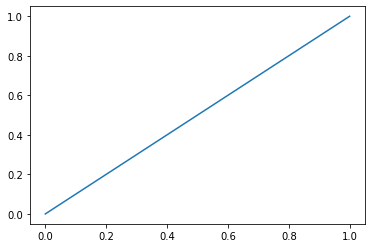

In [5]:
# DO NOT MODIFY THIS BLOCK

phase_generator = LinearPhaseGenerator()

phase_generator.plot(time)

### Basis Generator

Plot basis functions

The basis function matrix can be generated using the function *basis_generator.basis(time)* which you will need later on

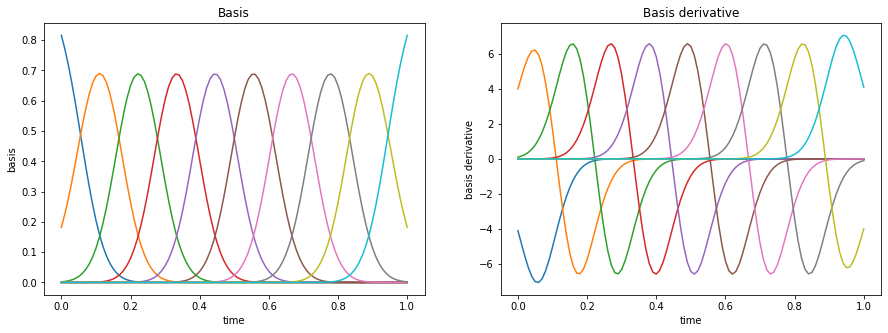

(101, 10)


In [6]:
# DO NOT MODIFY THIS BLOCK

basis_generator = NormalizedRBFBasisGenerator(phase_generator)

basis_generator.plot_single_dof(time)

basis_functions = basis_generator.basis(time)
print(basis_functions.shape)  # shape = [num time steps, num basis functions]

### ProMP

Generate a ProMP using the defined basis function generator and a random mean and covariance and plot the mean trajectory with standard deviation

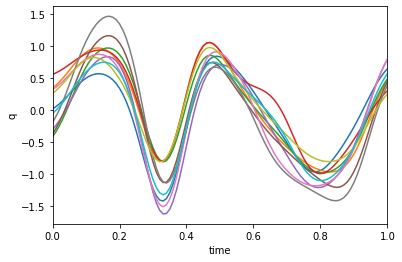

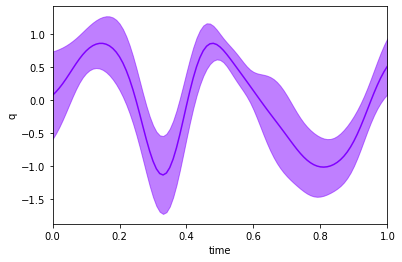

In [7]:
# DO NOT MODIFY THIS BLOCK

mp = ProMP(basis_generator)

mean = np.random.randn(num_basis)
mp.set_mean(mean)

a_mat = 0.1 * np.random.randn(num_basis, num_basis)
cov = a_mat @ a_mat.T
mp.set_cov_mat(cov)

mp.plot_trajectory_samples(time, 10)

mp.plot_promp(time)

### Learning the mean and covariance from recorded trajectories
80 trajectories have been recorded with their corresponding time steps

(80, 100)
(80, 100)


Text(0, 0.5, 'q')

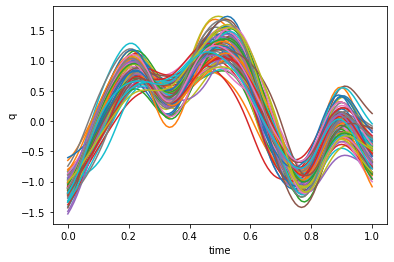

In [8]:
# DO NOT MODIFY THIS BLOCK

data = np.load("/tmp/times_and_tajectories.npz")
times = data['times']
trajectories = data['trajectories']
print(times.shape)
print(trajectories.shape)

plt.plot(times[0], trajectories.T);
plt.xlabel('time')
plt.ylabel('q')

## Exercise 4 a)
For your implementation, use *basis_generator.basis(time)* to generate the matrix of basis functions phi. Have a look at numpy function *np.linalg.solve* to solve the inverse without explicitly computing it. Finally, numpy functions *np.mean*, *np.cov*, *np.dot* or *np.matmul* can be helpful.

In [9]:
# TODO: implement the function body

def learn_from_data(n_weights: int, basis_generator: NormalizedRBFBasisGenerator,
                    trajectory_list: np.ndarray, time_list: np.ndarray):
    """
    n_weights: number of weights that need to be learned
    basis_generator: a basis generator object to generate basis functions
    trajectory_list: an array containinng demonstrations, shape=[num trajectories, num time steps]
    time_list: an array containing time points for each trajectory, shape=[num trajectories, num time steps]
    """
    regularization_coeff = 10**-9

    num_traj = len(trajectory_list)
    weight_matrix = np.zeros((num_traj, n_weights))
    for i in range(num_traj):

        trajectory = trajectory_list[i]
        time = time_list[i]
        basis_matrix = basis_generator.basis(time)
        temp = basis_matrix.transpose().dot(basis_matrix) \
               + np.eye(n_weights) * regularization_coeff
        weight_vector = np.linalg.solve(temp, basis_matrix.transpose().dot(trajectory))
        weight_matrix[i, :] = weight_vector

    mu = np.mean(weight_matrix, axis=0)

    cov = np.cov(weight_matrix.transpose())
    
    return mu, cov

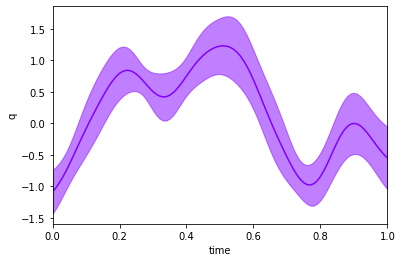

In [10]:
# DO NOT MODIFY THIS BLOCK

learned_mean, learned_cov = learn_from_data(10, basis_generator,trajectories, times)

learned_promp = ProMP(basis_generator)
learned_promp.set_mean(learned_mean)
learned_promp.set_cov_mat(learned_cov)

learned_promp.plot_promp(time)

## Exercise 4 b) Adapting the goal point
The function *joint_space_conditioning* takes the old motion primitive as input. Use its attributes *basis_generator*, *mu* and *cov_mat* to calculate the mean and covariance matrix of the adapted ProMP. The function *basis_generator.basis(time)* takes a single take point as input, too.

In [9]:
# TODO: implement the function body

def joint_space_conditioning(old_mp: ProMP, time: float, desired_theta: float, desired_var: float):
    """
    old_mp: The ProMP object to adapt
    time: the time point to adapt
    desired_theta: the desired value at the time point to adapt
    desired_var: variance at the adapted point
    """
    
    basis_matrix = old_mp.basis_generator.basis(time)
    temp = old_mp.cov_mat.dot(basis_matrix.transpose())
    L = np.linalg.solve(desired_var + basis_matrix.dot(temp), temp.transpose())
    L = L.transpose()
    new_mean = old_mp.mu + L.dot(desired_theta - basis_matrix.dot(old_mp.mu))
    new_cov_mat = old_mp.cov_mat - L.dot(basis_matrix).dot(old_mp.cov_mat)
    return new_mean, new_cov_mat

Non vectorized version for single DOF

In [11]:
def joint_space_conditioning(old_mp: ProMP, time: float, desired_theta: float, desired_var: float):
    """
    old_mp: The ProMP object to adapt
    time: the time point to adapt
    desired_theta: the desired value at the time point to adapt
    desired_var: variance at the adapted point
    """
    basis_matrix = old_mp.basis_generator.basis(time)
    temp = old_mp.cov_mat.dot(basis_matrix.transpose())
    L = temp / (desired_var + basis_matrix.dot(temp))
    new_mean = old_mp.mu + L.flatten() * (desired_theta - basis_matrix.dot(old_mp.mu))
    new_cov_mat = old_mp.cov_mat - L.dot(basis_matrix).dot(old_mp.cov_mat)
    return new_mean, new_cov_mat

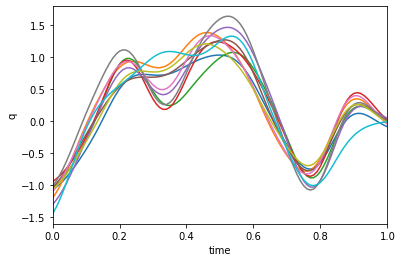

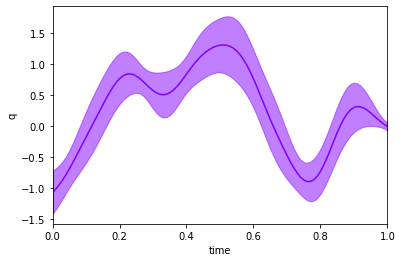

In [12]:
# DO NOT MODIFY THIS BLOCK
t_adapt = 1
q_des = 0
var_des = 0.001

new_mean, new_cov = joint_space_conditioning(learned_promp, t_adapt, q_des, var_des)

new_promp = ProMP(basis_generator)
new_promp.set_mean(new_mean)
new_promp.set_cov_mat(new_cov)

new_promp.plot_trajectory_samples(time, 10)

new_promp.plot_promp(time)